In [32]:
# import numpy as np
import numpy as np
%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2

from Functions import image_processing as ip
from Functions import seed_detection as sd
from Functions import seeded_region_growing as srg
from Functions import old_seeded_region_growing as old_srg
import skimage.io as sk
from Functions import region_merging as rm
from Functions import dice_score as ds

# from collections import Counter

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


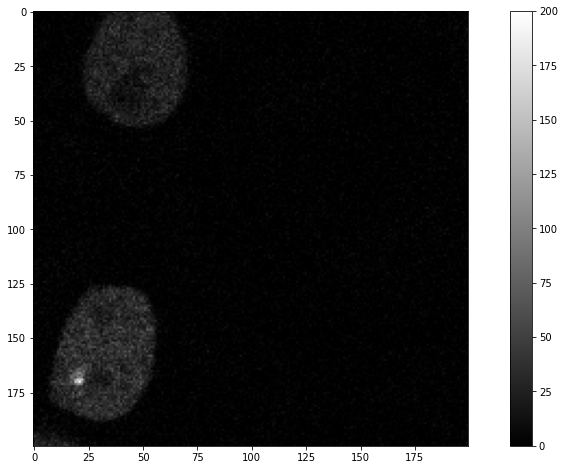

In [33]:
image_intensity = sk.imread("Data/N2DH-GOWT1/img/t31.tif")
image_intensity = image_intensity[300:500, 450:650]
image_gt = sk.imread("Data/N2DH-GOWT1/gt/man_seg01.tif")
image_gt = image_gt[300:500, 450:650]
ip.show_image(image_intensity, 15, 8)

0.085


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:50: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / (img[p] + 0.000001))


1000
2000
3000
4000
5000


KeyboardInterrupt: 

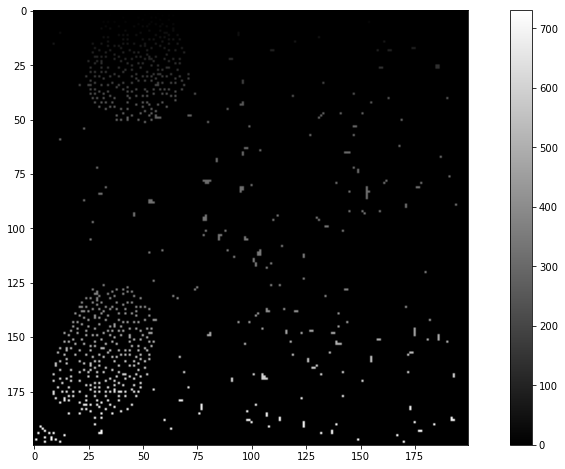

In [34]:
image_n = sd.seeds(image_intensity,0.9)
image_n = sd.seed_merging(image_n)
ip.show_image(image_n, 15, 8)
image_n_srg = srg.region_growing(image_intensity, image_n)
image_merged_n = rm.region_merging(image_n_srg.copy(),image_intensity, 0.005, 300)
ip.show_image(image_merged_n, 15, 8)
dice_score_weighted_n = ds.evaluate_accuracy_weighted(image_merged_n, image_gt)
dice_score_unweighted_n = ds.evaluate_accuracy_unweighted(image_merged_n, image_gt)
print(dice_score_weighted_n)
print(dice_score_unweighted_n)

In [ ]:
image_t = ip.image_clipping(image_intensity,0.1*np.amax(image_intensity),0.9*np.amax(image_intensity))
ip.show_image(image_t, 15, 8)
image_t_seed = sd.seeds(image_t, 0.9)
image_t_seed = sd.seed_merging(image_t_seed)
ip.show_image(image_t_seed, 15, 8)
image_srg = srg.region_growing(image_intensity, image_t_seed)
image_merged = rm.region_merging(image_srg.copy(), image_intensity, 0.005, 300)
ip.show_image(image_merged, 15, 8)
dice_score_weighted_t = ds.evaluate_accuracy_weighted(image_merged, image_gt)
dice_score_unweighted_t = ds.evaluate_accuracy_unweighted(image_merged, image_gt)
print(dice_score_weighted_t)
print(dice_score_unweighted_t)

0.085


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:50: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / (img[p] + 0.000001))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
0.4800313886337836
0.7238


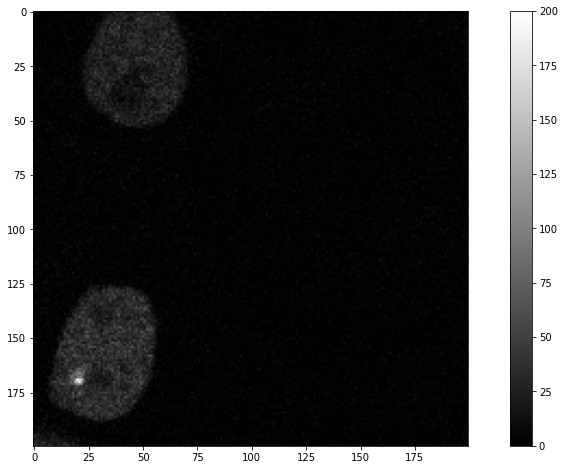

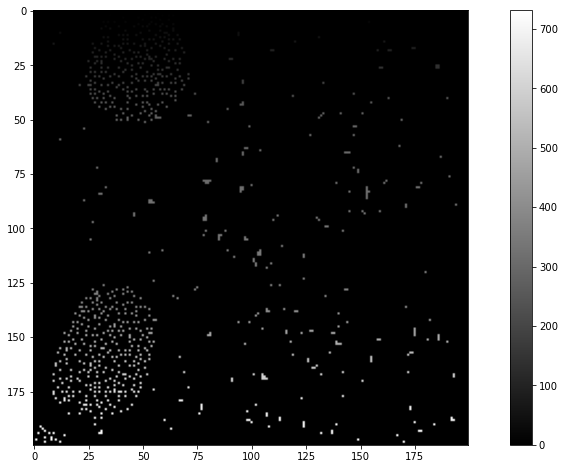

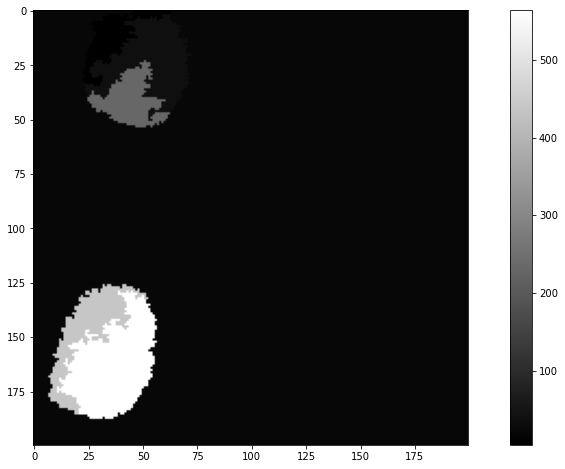

In [39]:
image_c = ip.image_clipping_extreme(image_intensity, 0, 0.8*np.amax(image_intensity))
ip.show_image(image_c, 15, 8)
image_c_seed = sd.seeds(image_c, 0.9)
image_c_seed = sd.seed_merging(image_c_seed)
ip.show_image(image_c_seed, 15, 8)
image_c_srg = srg.region_growing(image_intensity, image_c_seed)
image_merged_c = rm.region_merging(image_c_srg.copy(), image_intensity, 0.005, 300)
ip.show_image(image_merged_c, 15, 8)
dice_score_weighted_c = ds.evaluate_accuracy_weighted(image_merged_c, image_gt)
dice_score_unweighted_c = ds.evaluate_accuracy_unweighted(image_merged_c, image_gt)
print(dice_score_weighted_c)
print(dice_score_unweighted_c)

0.1368421052631579


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:50: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / (img[p] + 0.000001))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
0.5038371363603774
0.6702


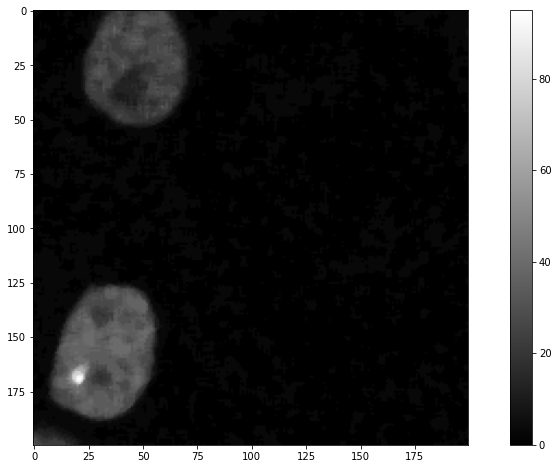

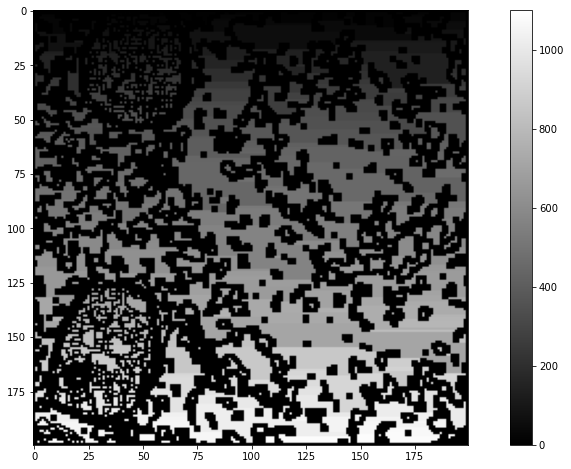

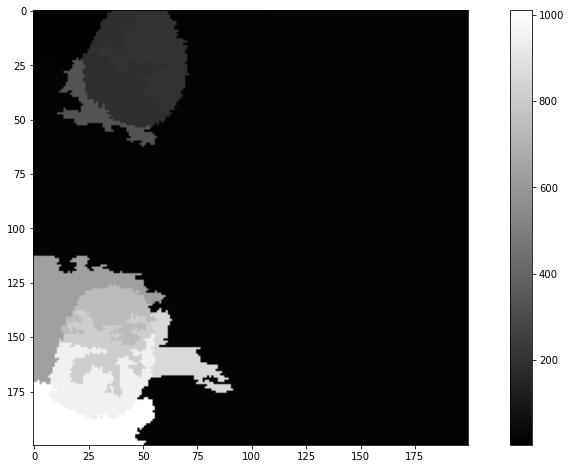

In [52]:
image_m = ip.median_filter(image_intensity, 4)
ip.show_image(image_m, 15, 8)
image_m_seed = sd.seeds(image_m, 0.9)
image_m_seed = sd.seed_merging(image_m_seed)
ip.show_image(image_m_seed, 15, 8)
image_m_srg = srg.region_growing(image_intensity, image_m_seed)
image_merged_m = rm.region_merging(image_m_srg.copy(), image_intensity,0.004, 400)
ip.show_image(image_merged_m, 15, 8)
dice_score_weighted_m = ds.evaluate_accuracy_weighted(image_merged_m, image_gt)
dice_score_unweighted_m = ds.evaluate_accuracy_unweighted(image_merged_m, image_gt)
print(dice_score_weighted_m)
print(dice_score_unweighted_m)

0.19117647058823528


C:\Users\ijung\PycharmProjects\2021-topic-04-team-04\Functions\seed_detection.py:50: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p] - img[i, j]) / (img[p] + 0.000001))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
0.4889740185004814
0.57125


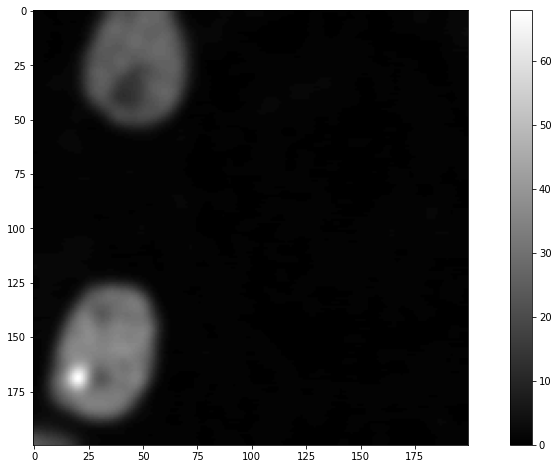

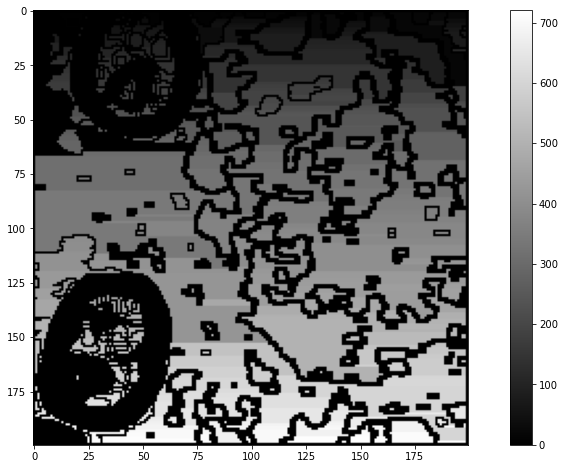

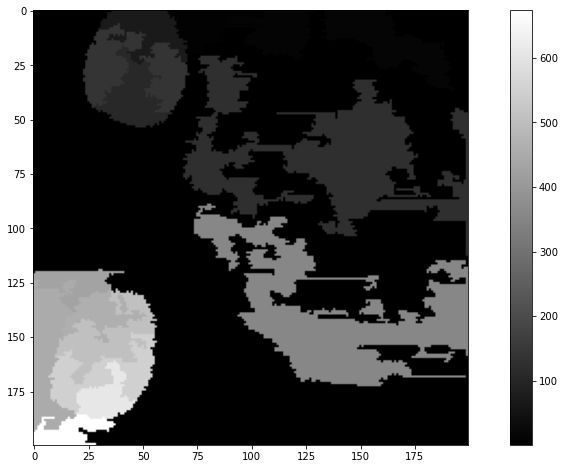

In [57]:
image_g = ip.gaussian_filter(image_intensity, 3)
ip.show_image(image_g, 15, 8)
image_g_seed = sd.seeds(image_g, 0.9)
image_g_seed = sd.seed_merging(image_g_seed)
ip.show_image(image_g_seed, 15, 8)
image_g_srg = srg.region_growing(image_intensity, image_g_seed)
image_merged_g = rm.region_merging(image_g_srg.copy(), image_intensity,0.005, 300)
ip.show_image(image_merged_g, 15, 8)
dice_score_weighted_g = ds.evaluate_accuracy_weighted(image_merged_g, image_gt)
dice_score_unweighted_g = ds.evaluate_accuracy_unweighted(image_merged_g, image_gt)
print(dice_score_weighted_g)
print(dice_score_unweighted_g)

C:\Users\ijung\anaconda3\envs\environmentGroup4\lib\site-packages\medpy\filter\smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
C:\Users\ijung\anaconda3\envs\environmentGroup4\lib\site-packages\medpy\filter\smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  matrices[i][slicer] = numpy.diff(matrices[i], axis=i)


0.080078125
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
0.5205516985888994
0.685375


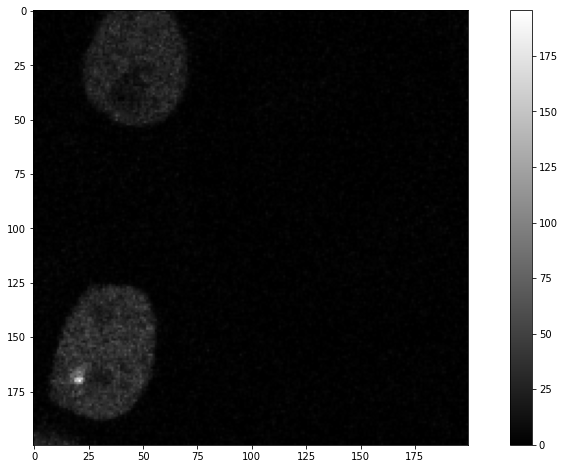

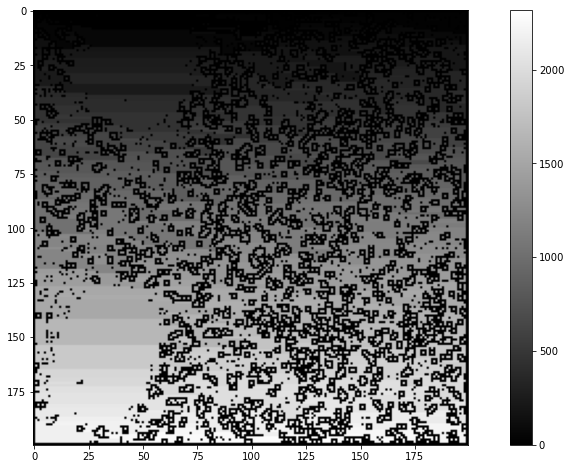

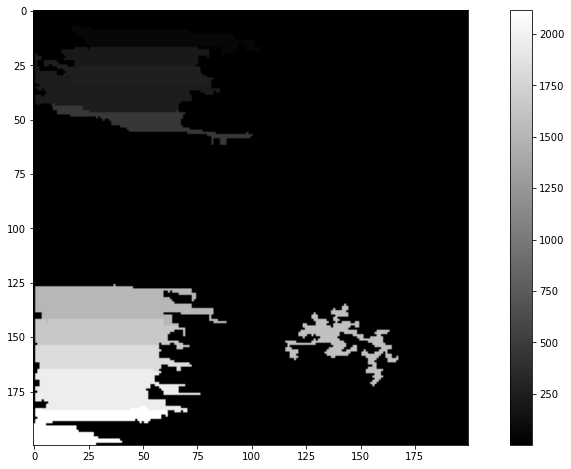

In [63]:
image_a = ip.anisotropic_filter(image_intensity)
ip.show_image(image_a, 15, 8)
image_a_seed = sd.seeds(image_a, 0.9)
image_a_seed = sd.seed_merging(image_a_seed)
ip.show_image(image_a_seed, 15, 8)
image_a_srg = srg.region_growing(image_intensity, image_a_seed)
image_merged_a = image_a_srg
image_merged_a = rm.region_merging(image_a_srg.copy(), image_intensity, 0.004, 400)
ip.show_image(image_merged_a, 15, 8)
dice_score_weighted_a = ds.evaluate_accuracy_weighted(image_merged_a, image_gt)
dice_score_unweighted_a = ds.evaluate_accuracy_unweighted(image_merged_a, image_gt)
print(dice_score_weighted_a)
print(dice_score_unweighted_a)




normal:
otsu = 0.085
seed: 0.9 #doesn't change for 0.8, lower for 0.7
merging parameters: 0.005 & 300 #best value
dsw = 0.50
dsu = 0.73

same setting for seed & merging parameters:
clipping (only grey??):
0.15*np.amax(image_intensity),0.85*np.amax(image_intensity)
ostu =0.23
dsw = 0.44
dsu = 0.79

clipping extreme:
0, 0.8*np.amax(image_intensity) #when lower value higher otsu zero & lower dice score
ostu =0.085
dsw = 0.5
dsu = 0.73

median size of filter 4:
other settings for merging: 0.04 & 400
ostu =0.09
dsw = 0.50
dsu = 0.67

gauss size of filter 3 or 4(equally):
ostu =0.19
dsw = 0.49
dsu = 0.57

anisotrophic:
other parameters for merging: 0.004 & 400
ostu =0.08
dsw = 0.52
dsu = 0.69